# Punctuation Modeling - Commas, Fullstops and Captilization

## Installing all the libraries

In [1]:
!pip install matplotlib scikit-learn

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 2.1.1+cu118


In [3]:
!pip install wikipedia

  Using cached wikipedia-1.4.0-py3-none-any.whl


## Dataset

### For this model, we have two pieces of data. The first one is the Wikipedia text of 1000 nouns (deleting missing), and the second is 1100 novels from Gutenberg Dataset. Here, we take the first 1000 nouns and get the Wikipedia text

In [ ]:
import os
import wikipedia

with open('nounlist.txt', 'r') as file:
    nouns = [line.strip() for line in file.readlines()]

wikipedia_texts = []
for noun in nouns[:1000]:
    try:
        page = wikipedia.page(noun)
        wikipedia_texts.append(page.content)
    except wikipedia.exceptions.PageError:
        continue
    except wikipedia.exceptions.DisambiguationError as e:
        continue


/opt/conda/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /opt/conda/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [7]:
raw_data = ' '.join(wikipedia_texts)
print(raw_data[:100])
print(len(raw_data))

T, or t, is the twentieth letter of the Latin alphabet, used in the modern English alphabet, the alp
17002701


### We also take the list of books from the dataset.

In [8]:

novel_texts = []
books_directory = 'books/'
novel_filenames = sorted(os.listdir(books_directory))[:50] 

for filename in novel_filenames:
    with open(os.path.join(books_directory, filename), 'r', encoding='utf-8') as file:
        novel_texts.append(file.read())

books_data = ' '.join(novel_texts)
print(len(novel_texts))
print(books_data[:100])

50

LINCOLN LETTERS

By Abraham Lincoln


Published by The Bibilophile Society




NOTE

The letters he


## Pre-processing

### We only consider commas and fullstops for this model, hence we should either delete or replace other characters and punctuations. Additionally, we have converted all numbers to 1. Finally, we have removed all other characters from the text.

In [9]:
import re
from random import sample
from collections import defaultdict

raw_text = raw_data + " " + books_data

to_comma = [":", ";"]
to_period = ["!", "?"]
to_white_space = ["-", "\n"]
to_one = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

replace_comma = str.maketrans(''.join(to_comma), ',' * len(to_comma))
replace_period = str.maketrans(''.join(to_period), '.' * len(to_period))
replace_whitespace = str.maketrans(''.join(to_white_space), ' ' * len(to_white_space))
replace_one = str.maketrans(''.join(to_one), '1' * len(to_one))

def to_null(translation_table, text):
    return text.translate(translation_table)

def remove_unwanted_characters(text):
    return re.sub(r'[^\w\s,.]', '', text)

def to_pure_text(text):
    # Replacing specified characters with a comma or period
    text = text.translate(replace_comma).translate(replace_period)
    # Replacing digits with '1'
    text = text.translate(replace_one)
    # Removing all non-English characters and non-specified punctuation
    text = re.sub(r'[^a-zA-Z1,. ]', '', text)
    # Substituting multiple occurrences of '1' with the word 'one'
    text = re.sub(r'1+', 'one', text)
    # Ensuring spaces before and after periods and commas
    text = re.sub(r'\s*([,.])\s*', r'\1 ', text)
    # Replacing multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Converting to lowercase
    text = text.lower().strip()
    return text

pure_text = to_pure_text(raw_text)

print("Length of split by spaces:", len(pure_text.split()))
print("Length of split by words:", len(re.findall(r'\w+', pure_text)))


Length of split by spaces: 5281836
Length of split by words: 5272600


In [10]:
print(pure_text[10000:12000])

ir. the hair on the majority of its body is grouped in clusters of one hairs. the hair surrounding its nostrils is dense to help filter particulate matter out as it digs. its tail is very thick at the base and gradually tapers. head the greatly elongated head is set on a short, thick neck, and the end of the snout bears a disc, which houses the nostrils. it contains a thin but complete zygomatic arch. the head of the aardvark contains many unique and different features. one of the most distinctive characteristics of the tubulidentata is their teeth. instead of having a pulp cavity, each tooth has a cluster of thin, hexagonal, upright, parallel tubes of vasodentin a modified form of dentine, with individual pulp canals, held together by cementum. the number of columns is dependent on the size of the tooth, with the largest having about one, one. the teeth have no enamel coating and are worn away and regrow continuously. the aardvark is born with conventional incisors and canines at the 

### We then generate the corresponding tagging given a piece of text with punctuation.

In [11]:
def divide_into_segments(text, segment_length=200):
    words = text.split()
    return [words[i:i+segment_length] for i in range(0, len(words), segment_length)]

def tag_punctuation_and_prepare_segments(words_segment):
    tagged_segment = [('a' if word.endswith('.') else 'b' if word.endswith(',') else 'c', re.sub(r'[,.]', '', word)) for word in words_segment]
    words, tags = zip(*tagged_segment) 
    return list(words), list(tags)

word_segments = divide_into_segments(pure_text, 200)
tagged_data = [tag_punctuation_and_prepare_segments(segment) for segment in word_segments if len(segment) <= 200]

total_data = [(words, tags) for words, tags in tagged_data if len(words) == 200 or (len(words) < 200 and tagged_data.index((words, tags)) == len(tagged_data) - 1)]

print(len(total_data))


26410


In [12]:
print(len(tagged_data))

26410


In [13]:
print(len(total_data))

26410


In [14]:
for tags, words in tagged_data[:15]:
    print(len(words))

200
200
200
200
200
200
200
200
200
200
200
200
200
200
200


In [15]:
print(tagged_data[23139])
print(tagged_data[23140])
#print(total_data[0])

#print(len(word_segments[0]))

(['c', 'c', 'b', 'c', 'c', 'c', 'c', 'b', 'c', 'c', 'c', 'b', 'c', 'c', 'c', 'c', 'c', 'a', 'c', 'b', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'b', 'c', 'c', 'c', 'c', 'c', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'b', 'c', 'c', 'a', 'c', 'c', 'c', 'c', 'c', 'b', 'c', 'c', 'c', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'a', 'c', 'c', 'c', 'c', 'b', 'c', 'c', 'b', 'c', 'c', 'c', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'b', 'c', 'c', 'b', 'c', 'c', 'c', 'c', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'b', 'c', 'c', 'c', 'c', 'c', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'b', 'c', 'c', 'c', 'c', 'a', 'c', 'c', 'c', 'c', 'c', 'b', 'c', 'b', 'c', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'a', 'c', 'c', 'c', 'c', 'c', 'b', 'c', 'c', 'c', 'c', 'a', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'b', 'c', 'c', 'c', 'c', 'c', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'b', 'c', 'c'

### Here we build the vocalbulary

In [16]:
from collections import Counter

all_words = [word for _, tokens in total_data for word in tokens]

# Building the vocabulary
vocab_count = Counter(all_words)
word_to_idx = {word: idx + 1 for idx, (word, _) in enumerate(vocab_count.items())}
word_to_idx["<UNK>"] = 0

vocab_size = len(word_to_idx) 

In [17]:
print(word_to_idx['imprints'])

66100


In [18]:
def text_to_sequence(tokenized_text, word_to_idx):
    return [word_to_idx.get(word, word_to_idx["<UNK>"]) for word in tokenized_text]

total_data_indices = [([tag for tag in tags], text_to_sequence(tokens, word_to_idx)) for tags, tokens in total_data]

tag_to_idx = {'a': 0, 'b': 1, 'c': 2}

total_data_prepared = [([tag_to_idx[tag] for tag in tags], tokens) for tags, tokens in total_data_indices]



In [19]:
print(total_data_prepared[0])

([1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2], [1, 2, 1, 3, 4, 5, 6, 7, 4, 8, 9, 10, 11, 4, 12, 13, 9, 4, 14, 7, 15, 16, 17, 18, 19, 20, 21, 22, 23, 11, 13, 3, 24, 25, 26, 27, 28, 3, 29, 30, 4, 31, 32, 7, 4, 33, 19, 34, 35, 36, 19, 37, 32, 38, 32, 19, 39, 1, 40, 4, 41, 6, 42, 11, 13, 28, 3, 43, 44, 10, 45, 46, 4, 47, 48, 49, 50, 51, 28, 52, 53, 11, 4, 54, 55, 9, 28, 3, 4, 43, 44, 10, 56, 19, 4, 57, 44, 10, 6, 11, 58, 59, 60, 32, 61, 4, 62, 

## Training

## Spliting the total data we have condensed to training, validation and test ratio.

In [20]:
from random import shuffle

total_length = len(total_data)
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10 

train_split = int(total_length * train_ratio)
validation_split = train_split + int(total_length * validation_ratio)

indices = list(range(total_length))
shuffle(indices)

training_set = [total_data_prepared[i] for i in indices[:train_split]]
validation_set = [total_data_prepared[i] for i in indices[train_split:validation_split]]
test_set = [total_data_prepared[i] for i in indices[validation_split:]]

In [21]:
print(len(training_set))
print(training_set[0])

19807
([2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2], [170721, 2443, 1335, 650, 26364, 19, 11833, 599, 19, 402, 171757, 4647, 721, 133611, 82, 4207, 5549, 345, 124, 342, 5139, 180864, 1350, 1015, 286, 100, 4207, 608, 12816, 2, 6433, 4207, 1545, 98694, 11, 4, 16549, 7, 20829, 22673, 180865, 86161, 30150, 19, 180866, 2034, 7, 4, 7833, 20272, 555, 4, 12302, 988, 180867, 282, 7, 4, 1901, 2759, 1350, 86, 1317, 291, 180868, 144, 124, 887, 4207, 47

In [22]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    words, tags = zip(*batch)
    
    words_padded = pad_sequence(words, batch_first=True, padding_value=0)  
    tags_padded = pad_sequence(tags, batch_first=True, padding_value=0) 
    
    return words_padded, tags_padded


In [23]:
from torch.utils.data import Dataset, DataLoader
import torch

class PunctuationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tags, tokens = self.data[idx]
        return torch.tensor(tokens, dtype=torch.long), torch.tensor(tags, dtype=torch.long)

batch_size = 32 

train_dataset = PunctuationDataset(training_set)
val_dataset = PunctuationDataset(validation_set)
test_dataset = PunctuationDataset(test_set)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [24]:
for labels, inputs in train_dataloader:
    print(inputs.dtype, labels.dtype)
    print(inputs.shape, labels.shape)
    break 


torch.int64 torch.int64
torch.Size([32, 200]) torch.Size([32, 200])


In [25]:
vocab_size = len(word_to_idx) 
print(vocab_size)

229260


### For this model, we use the glove embeddings as the embedding layer. The embedding layer is used to change words into vectors that represent their semantic characteristics.

In [26]:
def load_glove_embeddings(path):
    embeddings_dict = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float)
            embeddings_dict[word] = vector
    return embeddings_dict

glove_path = 'glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_path)


In [27]:
embedding_dim = 100  # GloVe 100-dimensional vectors
print(vocab_size)

embedding_matrix = torch.zeros((vocab_size, embedding_dim))

for word, idx in word_to_idx.items():
    if idx >= vocab_size:
        continue
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]
    else:
        embedding_matrix[idx] = torch.randn(embedding_dim)


229260


In [28]:
print(embedding_matrix[0])

tensor([ 0.4724,  0.2270, -0.4743,  0.1719,  0.9573,  0.2646,  1.3225, -0.3482,
         1.7004, -0.8220,  1.1364, -0.6759, -0.3743, -0.1851, -2.4039, -0.5341,
        -0.2271,  1.8260, -0.6606, -0.6483,  0.6405,  0.3656, -0.3934,  0.5835,
        -0.0914, -0.3217, -0.8237, -2.3008,  1.5760, -0.7516, -0.5039, -0.3551,
        -0.1450,  0.3043,  0.1004,  2.2663,  1.1313, -0.7747,  0.2311, -1.1938,
         0.5737,  0.0850,  0.9715, -1.2466,  1.2298,  0.7593,  0.6419, -2.5115,
         0.2672, -0.8378,  0.7068, -1.3269, -1.5178,  0.4476,  0.1263,  0.2504,
        -1.6747, -0.1561,  0.6752,  0.1699, -0.0925, -0.3503,  0.5907,  0.6047,
        -0.9527, -0.7762,  2.0054, -2.1857,  1.0045, -0.2163, -1.8431,  0.8421,
        -1.3256,  1.1123,  1.0672, -1.0580, -0.4344, -0.4151, -1.0957, -2.1345,
        -0.7316, -1.8595, -0.6591,  1.0850, -0.8278, -0.3084,  0.1107, -0.6854,
        -0.0681,  1.2706,  0.8094, -0.7294,  0.0894, -0.8424,  0.0762,  0.8459,
        -1.2592, -1.3931,  0.5867,  0.11

### Model

In [29]:
class PunctuationRestorationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pretrained_embeddings):
        super(PunctuationRestorationModel, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(pretrained_embeddings)  # Initialize with GloVe
        
        # LSTM layer followed by Bidirectional LSTM and GRU layers
        self.lstm1 = nn.LSTM(embedding_dim, 100, batch_first=True)
        
        # Bidirectional LSTM layer
        self.bidirectional_lstm_gru = nn.LSTM(100, 40, batch_first=True, bidirectional=True)
        
        # A second Bidirectional LSTM layer
        self.bidirectional_lstm2 = nn.LSTM(80, 20, batch_first=True, bidirectional=True)  
        
        # Final LSTM layer
        self.lstm2 = nn.LSTM(40, 10, batch_first=True) 
        
        # Linear layer that maps the LSTM layer outputs to 3 classes
        self.fc = nn.Linear(10, output_dim)
        
    def forward(self, x):
        # Embedding layer
        embedded = self.embedding(x)
        
        # First LSTM layer
        lstm_out, _ = self.lstm1(embedded)
        
        # Bidirectional LSTM/GRU layer
        bidirectional_out, _ = self.bidirectional_lstm_gru(lstm_out)
        
        # Simulating the second bidirectional layer (GRU behavior with LSTM for demonstration)
        bidirectional_out2, _ = self.bidirectional_lstm2(bidirectional_out)
        
        # Final LSTM layer
        final_out, _ = self.lstm2(bidirectional_out2)
        
        out = self.fc(final_out)
        
        return out

output_dim = 3  # For 'a', 'b', 'c' classes

model = PunctuationRestorationModel(vocab_size, embedding_dim, output_dim, embedding_matrix)
print(model)


PunctuationRestorationModel(
  (embedding): Embedding(229260, 100)
  (lstm1): LSTM(100, 100, batch_first=True)
  (bidirectional_lstm_gru): LSTM(100, 40, batch_first=True, bidirectional=True)
  (bidirectional_lstm2): LSTM(80, 20, batch_first=True, bidirectional=True)
  (lstm2): LSTM(40, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=3, bias=True)
)


## Running the model with its parameters

In [30]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
num_epochs = 15 
train_loss = []
val_loss = []

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    
    for inputs, labels in train_dataloader:
        optimizer.zero_grad() 
        
        outputs = model(inputs)
        loss = loss = criterion(outputs.view(-1, 3), labels.view(-1))
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_dataloader)}')
    train_loss.append(running_loss / len(train_dataloader))
    
    model.eval() 
    val_loss = 0.0
    with torch.no_grad(): 
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = loss = criterion(outputs.view(-1, 3), labels.view(-1))
            val_loss += loss.item()
    
    print(f'Validation Loss: {val_loss / len(val_dataloader)}')
    val_loss.append(val_loss / len(val_dataloader))


Epoch 1, Loss: 0.43779333429305733
Validation Loss: 0.3351297008414422
Epoch 2, Loss: 0.3066768998668344
Validation Loss: 0.2887669945916822
Epoch 3, Loss: 0.266725469025541
Validation Loss: 0.2705959228257979


### Saving the model for evaluation

In [32]:
model_path = 'model/model_epoch_3_loss_0_266_val_loss_0_27.pth'
torch.save(model.state_dict(), model_path)

### Plotting the losses

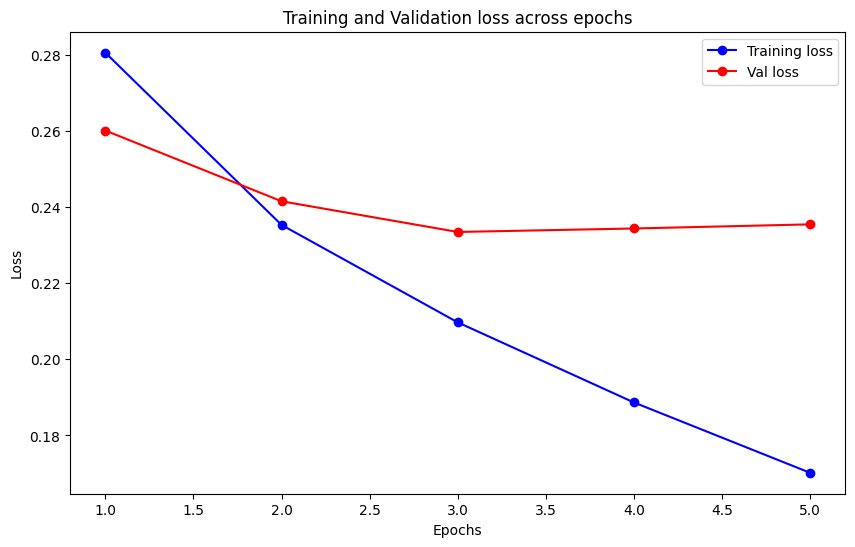

In [5]:
train_losses = [0.2805803467309912, 0.23533610785038683, 0.20973989658096698, 0.18869921522146743, 0.17021910896944126, 0.153000446602078, 0.1370327189876771, 0.1226843575708061, 0.10961413265483853, 0.09813242596305946, 0.08786856111977737, 0.0786041518556276]
val_losses = [0.2601284298047521, 0.24155115594271742, 0.23348241635397368, 0.23439599807355918, 0.235477026478917, 0.24343211052854077, 0.2613735952798058, 0.2732484840294894, 0.28687554519940045, 0.3051984876978631, 0.31898364424705505, 0.33021486740486294]

epochs = range(1, 6)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses[:5], 'bo-', label='Training loss')
plt.plot(epochs, val_losses[:5], 'ro-', label='Val loss')
plt.title('Training and Validation loss across epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Other evaluation metrics

In [33]:
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        all_preds.extend(torch.argmax(outputs, dim=2).flatten().tolist())
        all_labels.extend(labels.flatten().tolist())

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score

realTag = [1 if tag == 1 else 2 if tag == 2 else 0 for tag in all_labels]
resultTag = [1 if pred == 1 else 2 if pred == 2 else 0 for pred in all_preds]

prec_period = precision_score(realTag, resultTag, labels=[1], average='macro')
rec_period = recall_score(realTag, resultTag, labels=[1], average='macro')
f1_period = f1_score(realTag, resultTag, labels=[1], average='macro')

prec_comma = precision_score(realTag, resultTag, labels=[2], average='macro')
rec_comma = recall_score(realTag, resultTag, labels=[2], average='macro')
f1_comma = f1_score(realTag, resultTag, labels=[2], average='macro')

print(f"Precision (Period): {prec_period}, Recall (Period): {rec_period}, F1 (Period): {f1_period}")
print(f"Precision (Comma): {prec_comma}, Recall (Comma): {rec_comma}, F1 (Comma): {f1_comma}")


Precision (Period): 0.5938437560880576, Recall (Period): 0.3391863622201451, F1 (Period): 0.4317624895536764
Precision (Comma): 0.9365478347411131, Recall (Comma): 0.9678465707184251, F1 (Comma): 0.9519400052524585


## Evaluating with real text

In [35]:
def preprocess_text(text, word_to_idx):
    tokens = text.lower().split()
    indices = [word_to_idx.get(token, word_to_idx["<UNK>"]) for token in tokens]
    return torch.tensor(indices, dtype=torch.long).unsqueeze(0) 


In [36]:
def predict(text, model, word_to_idx, idx_to_tag):
    model.eval() 
    with torch.no_grad():
        indices = preprocess_text(text, word_to_idx)
        outputs = model(indices)
        predictions = torch.argmax(outputs, dim=2) 
    predicted_tags = [idx_to_tag[idx.item()] for idx in predictions.squeeze()] 
    return predicted_tags


In [37]:
idx_to_tag = {0: 'a', 1: 'b', 2: 'c'}  

def apply_predicted_tags(text, predicted_tags):
    tokens = text.lower().split()
    final_text = ""
    for token, tag in zip(tokens, predicted_tags):
        if tag == 'a':  # 'a' is for periods
            final_text += token + ". "
        elif tag == 'b':  # 'b' is for commas
            final_text += token + ", "
        else:  # 'c' or other tags mean no punctuation
            final_text += token + " "
    return final_text.strip()


In [44]:
def capitalize_after_fullstop(text):
    sentences = text.split('. ')
    capitalized_sentences = [sentence.strip().capitalize() for sentence in sentences]
    capitalized_text = '. '.join(capitalized_sentences)
    return capitalized_text

In [45]:
def predict_and_apply_tags(text, model, word_to_idx, idx_to_tag):
    predicted_tags = predict(text, model, word_to_idx, idx_to_tag) 
    final_text = apply_predicted_tags(text, predicted_tags)
    capitalized_text = capitalize_after_fullstop(final_text)
    return capitalized_text

In [59]:
ori_text = "Bryant started playing basketball when he was three, and the Lakers were his favorite team when he was growing up. When he was six, his father retired from \
the NBA and moved his family to Rieti in Italy to continue playing professional basketball. After two years, they moved first to Reggio Calabria, then to Pistoia and \
Reggio Emilia. Kobe became accustomed to his new lifestyle and learned to speak fluent Italian. He was especially fond of Reggio Emilia, which he considered a loving \
place and where some of his best childhood memories were made. He began to play basketball seriously while living in Reggio Emilia. His grandfather mailed him videos \
of NBA games for him to study. Another source of inspiration was animated European films about sports, from which he learned more about basketball. From 1987 to 1989, \
his father played for Olimpia Basket Pistoia where he paired with former Detroit Pistons player Leon Douglas. Kobe worked at the games as a ball and mop boy and practiced \
shooting at halftime. \
Bryant was sidelined for six weeks prior to the start of the 1999–2000 season due to a hand injury that he had incurred during a preseason game against the \
Washington Wizards. When Bryant was back and playing over 38 minutes a game, he had an increase in all statistical categories during the 1999–2000 season. This included \
leading the team in assists per game and steals per game. The duo of O'Neal and Bryant backed with a strong bench led to the Lakers winning 67 games, tied for fifth-most \
in NBA history. This followed with O'Neal winning the MVP and Bryant being named to the All-NBA Second Team and All-NBA Defensive Team for the first time in his career\
(the youngest player to receive All-Defensive honors). While playing second fiddle to O'Neal in the playoffs, Bryant had some clutch performances, including a 25-point, \
11-rebound, 7-assist, 4-block game in Game 7 of the Western Conference Finals against the Portland Trail Blazers. He also threw an alley-oop pass to O'Neal to clinch the \
game and the series. In the 2000 Finals, against the Indiana Pacers, Bryant injured his ankle in the second quarter of Game 2 after landing on the Pacers' Jalen Rose's \
foot. Rose later admitted he placed his foot under Bryant intentionally. Bryant did not return to the game, and he also missed Game 3 due to the injury. In Game 4, Bryant \
scored 22 points in the second half and led the team to an OT victory as O'Neal fouled out of the game. Bryant scored the winning shot to put the Lakers ahead 120–118. \
With a 116–111 victory in Game 6, the Lakers won their first championship since 1988.\
On My World 2.0, Bieber's voice was noted to be deeper than it was in his debut EP, due to puberty. In April 2010, the singer remarked regarding his vocals: 'It cracks. \
Like every teenage boy, I'm dealing with it and I have the best vocal coach in the world ... Some of the notes I hit on 'Baby' I can't hit any more. We have to lower the \
key when I sing live.' Bieber guest-starred in the season premiere of the CBS American crime drama CSI: Crime Scene Investigation, which aired on September 23, 2010. He \
played a 'troubled teen who is faced with a difficult decision regarding his only brother', who is also a serial bomber. Bieber was also in a subsequent episode of the \
series, which aired on February 17, 2011, in which his character is killed. Bieber performed a medley of his singles 'U Smile', 'Baby', and 'Somebody to Love', and briefly \
played the drums, at the 2010 MTV Video Music Awards on September 12, 2010. Bieber announced in October 2010 that he would be releasing an acoustic album, called My Worlds \
Acoustic. It was released on November 26, 2010, in the United States and featured acoustic versions of songs from his previous albums, and accompanied the release of a \
new song titled 'Pray'. In October 2010, Bieber released his first book, Justin Bieber: First Step 2 Forever: My Story, an autobiography with text from Bieber and \
photographs from Robert Caplin."

In [60]:
text = "bryant started playing basketball when he was three and the lakers were his favorite team when he was growing up when he was six his father retired from the nba \
and moved his family to rieti in italy to continue playing professional basketball after two years they moved first to reggio calabria then to pistoia and reggio emilia \
kobe became accustomed to his new lifestyle and learned to speak fluent italian he was especially fond of reggio emilia which he considered a loving place and where some \
of his best childhood memories were made he began to play basketball seriously while living in reggio emilia his grandfather mailed him videos of nba games for him to \
study another source of inspiration was animated european films about sports from which he learned more about basketball from 1987 to 1989 his father played for olimpia \
basket pistoia where he paired with former detroit pistons player leon douglas kobe worked at the games as a ball and mop boy and practiced shooting at halftime bryant was \
sidelined for six weeks prior to the start of the 1999–2000 season due to a hand injury that he had incurred during a preseason game against the washington wizards when \
bryant was back and playing over 38 minutes a game he had an increase in all statistical categories during the 1999–2000 season this included leading the team in assists \
per game and steals per game the duo of o'neal and bryant backed with a strong bench led to the lakers winning 67 games tied for fifth-most in nba history this followed \
with o'neal winning the mvp and bryant being named to the all-nba second team and all-nba defensive team for the first time in his career (the youngest player to receive \
all-defensive honors) while playing second fiddle to o'neal in the playoffs bryant had some clutch performances including a 25-point 11-rebound 7-assist 4-block game in \
game 7 of the western conference finals against the portland trail blazers he also threw an alley-oop pass to o'neal to clinch the game and the series in the 2000 finals \
against the indiana pacers bryant injured his ankle in the second quarter of game 2 after landing on the pacers' jalen rose's foot rose later admitted he placed his foot \
under bryant intentionally bryant did not return to the game and he also missed game 3 due to the injury in game 4 bryant scored 22 points in the second half and led the \
team to an ot victory as o'neal fouled out of the game bryant scored the winning shot to put the lakers ahead 120–118 with a 116–111 victory in game 6 the lakers won \
their first championship since 1988 \
on my world 20 biebers voice was noted to be deeper than it was in his debut ep due to puberty in april 2010 the singer remarked regarding his vocals 'it cracks like every \
teenage boy im dealing with it and i have the best vocal coach in the world  some of the notes i hit on 'baby' i cant hit any more we have to lower the key when i sing \
live' bieber guest-starred in the season premiere of the cbs american crime drama csi crime scene investigation which aired on september 23 2010 he played a 'troubled \
teen who is faced with a difficult decision regarding his only brother' who is also a serial bomber bieber was also in a subsequent episode of the series which aired on \
february 17 2011 in which his character is killed bieber performed a medley of his singles 'u smile' 'baby' and 'somebody to love' and briefly played the drums at the \
2010 mtv video music awards on september 12 2010 bieber announced in october 2010 that he would be releasing an acoustic album called my worlds acoustic it was released \
on november 26 2010 in the united states and featured acoustic versions of songs from his previous albums and accompanied the release of a new song titled 'pray' in \
october 2010 bieber released his first book justin bieber first step 2 forever my story an autobiography with text from bieber and photographs from robert caplin"

In [61]:
final_text_with_tags = predict_and_apply_tags(text, model, word_to_idx, idx_to_tag)
print(ori_text)
print("")
print(final_text_with_tags)


Bryant started playing basketball when he was three, and the Lakers were his favorite team when he was growing up. When he was six, his father retired from the NBA and moved his family to Rieti in Italy to continue playing professional basketball. After two years, they moved first to Reggio Calabria, then to Pistoia and Reggio Emilia. Kobe became accustomed to his new lifestyle and learned to speak fluent Italian. He was especially fond of Reggio Emilia, which he considered a loving place and where some of his best childhood memories were made. He began to play basketball seriously while living in Reggio Emilia. His grandfather mailed him videos of NBA games for him to study. Another source of inspiration was animated European films about sports, from which he learned more about basketball. From 1987 to 1989, his father played for Olimpia Basket Pistoia where he paired with former Detroit Pistons player Leon Douglas. Kobe worked at the games as a ball and mop boy and practiced shooting

In [66]:
ori_text_2 = "In the last section, we examined some early aspects of memory. In this section, what we’re going to do is discuss some factors that influence memory. So let’s do that by beginning with the concept on slide two, and that concept is overlearning. Basically in overlearning, the idea is that you continue to study something after you can recall it perfectly. So you study some particular topic whatever that topic is. When you can recall it perfectly, you continue to study it. \
This is a classic way to help when one is taking comprehensive finals later in the semester. So when you study for exam one and after you really know it all, you continue to study it. That will make your comprehensive final easier. \
The next factor that will influence memory relates to what we call organization. In general, if you can organize material, you can recall it better. There are lots of different types of organizational strategies and I’ve listed those on slide four. So let’s begin by talking about the first organizational strategy called clustering and is located on page five. \
In clustering, basically you recall items better if you can recognize that there are two or more types of things in a particular list. So let’s give a couple of lists and show you some examples of that. These examples are shown in slide six. \
Let’s say that I give you the first list; north, cardinal, south, robin, east, wren, west, sparrow. Now if you can recognize that north, south, east and west are points on a compass and cardinal, robin, wren and sparrow are birds, then you have a higher probability of recalling that material than if you just tried to recall the list in order. \
The same occurs with the second list that is located on the right hand side of page six. So let’s list these words as well; pig, cat, horse, dog, sheep, birds, cow, and fish. Now if you can recognize that these are two groups of animals; one being farm animals and the other being domestic companions, ala, pets, then you can recall that list of material better than if you just tried to recall the list in order. So again, this is another type of example of organizational strategy. \
Now there are other organizational strategies that one can use as well. The next one of these, as we see on slide seven, are what are called verbal pneumonic techniques. In verbal pneumonic techniques, you make your own organization and there are many, many different types of techniques. So let’s talk about the first of these on slide eight and that is called acrostics. In acrostics these are phrases in which the first letter of each word functions as a cue to help you recall some piece of information. There are a variety of different acrostics that one uses. The most famous of these relates to this saying: On Old Olympus Towering Tops A Fin And German Vented Some Hops. These relate to the twelve different cranial nerves that we have within the brain and if you are a traditional medical student or taking anatomy and physiology, this is the acrostic that you usually use to remember them. \
Now there are other verbal pneumonic techniques as well. So let’s take a look at another one of those and is located in slide 10. These are called acronyms. Acronyms are basically a word formed out of the first letters of a series of words. A classic example of an acronym system is ROY G BIV which are the first letters of the colors in the visual spectrum. This is the classic acronym that all sensation and perception students and even introductory psych students learn to memorize. Another verbal pneumonic technique is shown on slide 11 and called Rhymes. The classic rhyme is one that you had learned in grade school is I before E except after C. So rhymes are another way to recall and memorize information. \
So now we’ve examined a variety of different verbal pneumonic techniques and how they work. In this next section, we’re going to examine some visual imagery types of methods to organize material. \
The first of these is shown in slide 13 and is called the Method of Loci. Basically it involves taking some kind of an imaginary walk along some familiar path where images that you’re trying to recall are associated with some items or locations along the path. The classic example of where we put material is in your house. So just close your eyes and think about this. What happens when you walk in your back door? What’s the first item that you see. Well the first item that you see is where you put the first piece of information that you want to remember. Let’s say that it is a coat hook, so you hang something on the coat hook. Then you continue on into the kitchen. In the kitchen, what’s the first thing that you see? Well it may be the refrigerator, and so you identify the second item that you’re trying to remember and put it on the refrigerator. Then you open the door in the refrigerator and that’s where you put your third item. And then you close the refrigerator door and you look to your left and there’s the stove. So, you put the next item on one of the burners of the stove and on and on until you have all the items that you are trying to remember located within the kitchen or within the house. \
Then when you’re trying to recall the items during the exam, you begin your walk around the house. So the first thing you think about is what happens when I walk in the back door and lo and behold, there’s the first item I’m trying to recall. Then I go to the refrigerator and there’s the second item. Then I open the door of the refrigerator and there’s the third item and on and on until I have all the different materials that I’m trying to remember put down for my exam. \
Now walking around the house is a good place to use the method of loci, but there are other places that’s even better. The better place to try and place all the information you want to learn is in the location where you’re going to have to recall the material. So sitting in the exam room where you’re going to take the test and putting all those things on different objects within the exam room is a good strategy. Especially if one is trying to memorize lots and lots of different information because each of those places acts as a cue. \
So that’s the first type of visual imagery technique. Now the second type of visual imagery technique is shown on slide 14. This is called the pegword technique. The pegword technique relies on a list of integers. What you do is attach a pegword to each of the numbers with rhymes. The classic example is One rhyming with Bun, Two and Shoe, Three and Tree, Four and Door and on and on. Then as we see in slide 15, when you’re given a list of words to recall, you associate the first word in the list with the peg word. For example you have a word, let’s say you’re trying to recall the word “Bee” and the peg word is bun. Well what you might try to do is visualize a bee eating a great big bun. As a result of that, you make associations. Furthermore, the more outrageous the association, the better the recall is for the particular item. So, let’s say that you might have a frog with shoes on, and a horse knocking down a tree, or whatever it may be to the information that you’re trying to recall. \
So these are the first two techniques (overlearning, organization) that relate to factors that influence memory. What’s the next major factor? Well, the next major factor is shown on slides 16 and 17 and that is the order in which you learn things. If I give you a list of words in a serial learning task or a free recall task, you have better recall for words at the beginning and end of a list but not in the middle of a particular list. That is called the Serial Position Effect. There’s a couple different things you need to note about the serial position effect. First recall at the beginning of the list is what is called the Primacy Effect and recall for the end of the list is called the Recency Effect. The recency effect occurs because you can generally only recall seven plus or minus two items in working or what is also called short term memory. We’ll talk about that in more detail a little bit later. \
Now the serial position effect is shown in the graphical figure on slide 19. As we can see when we start to memorize a list of words, we usually start about 60 to 65% accuracy. In the recency phase, at the last word that we’re trying to recall we have a percent recall rate of about 85 to 90% depending on the study. Note within the middle of the list that you’re trying to look at you only have about a 20% chance of recalling a particular set of items. \
So the serial recall effect is extremely important for how you try to memorize things. For example, if you were studying three chapters for learning, as what we might have here, and you always start with the first chapter in order (so you start with chapter one, then two, then three), you will have fairly good recall for chapter one, you’ll have some decent recall also for chapter three but chapter two you won’t remember at all. So a better way to memorize that material is to change the order in which you’re learning the material. So you start one day with chapters one, two, and three in that order, then you go with two, three, and one; and finally, three, one and two, and on and on. What this does is help you raise the level of the middle section within the recency of effect. So, within the serial learning effect, what you should do is vary the order so you have good recall of information. \
Now there’s another variable that goes along with the serial position effect and is shown on slide 20. It is called the Von Resterhoff Effect. Basically when a word is in the middle of a list that is surprising or funny or dirty, you will usually recall that particular word and some of those around it. So let’s give an example of that in the following slide. \
Look on slide 21 at the list of words. What I’d like you to do is try to recall the words in order. So, take a minute to do that. \
Now that you have memorized and tried to recall the words, look in the middle of the list. Basically what happens is that everybody will recall the word 'intercourse' and usually a couple of words around it. So you might recall elephant and even suitcase. This effect is shown on slide 22. So, we have the same kind of effect that we saw with the serial learning task we began with on earlier slides. But we also see that in the middle of the list, we recall one or two particular words, then we drop off again before we have a recency effect (starting toward words 14 and 15). So again, the Von Resterhoff effect is an extremely important effect. You can use it to your advantage by putting surprising or interesting things in the middle of the list of material that you’re trying to memorize. \
Now the next factor that influences learning and memory is what we call proactive interference or what is also called proactive inhibition. Here is where your past learning will interfere with your ability to recall new material. Let’s give an example, if you learn list A, then you learn list B, and finally you have to recall B. In proactive interference, list A will interfere with your ability to recall list B. A classic example is shown on slide 24. You learn sociology then you learn psychology. Sociology will interfere with your ability to recall the psychology. To help keep it clear we have a little organizational scheme that kind of helps us. That is a classic acronym PABB. Proactive - You learn A, you learn B, then you recall B. \
Now sometimes your past learning will interfere with information retention or sometimes your past learning will help you because you learn to organize it better. We will talk about this in more detail in the next section. \
The next factor that influences memory is shown on slide 26 and that is what is called retroactive interference or retroactive inhibition. Unlike proactive interference, learning new material interferes with your ability to recall old material. That is, you learn list C, then you learn list D, then you have to recall C. Consequently, D will interfere with your ability to recall C. \
So let’s take an example of that. Here you learn psychology, then you learn sociology, and sociology will interfere with your ability to recall the psychology. So let’s take another example and use a more practical example. Let’s say that you’re learning psychology, (ala learning) and you’re going to take a test. You walk into the exam and you have about five minutes before the exam starts. So you take out a newspaper such as the Argonaut, which is our school newspaper and you start to read it. Consequently, the Argonaut will interfere with your ability to recall the psychology. Again we have another acronym and that is RCDC. Retroactive - you learn C, you learn D, then you have to recall the C. \
What are important things for you about proactive and retroactive interference from an applied standpoint. This is shown in slide 29. First of all, don’t take similar courses in the same semester. Take things that are different and that don’t have a lot of overlap. As a result you will recall all of them better. An example might be taking some sociology, some math, biology and computer science rather than taking sociology, psychology, anthropology, and maybe political science. If you do, things just get jumbled together. \
Now the next variable that’s going to influence learning is what is called active participation. In general, the more active you are during the learning cycle, the more you will recall, This is shown in slide 31. Quizzing yourself while you’re reading, determining how the material that you’re currently working with relates to other material, using study guides, outlining the chapters or notes, etc., will significantly increase your recall of information. \
The major one these relates to highlighting and chapter outlining or reading. If you look at and see which gives you the better recall, there is no doubt about it that outlining your book chapter will give you better recall than highlighting or reading the book. Let’s just take the concept of highlighting. What are you doing when you highlight a piece of text, let’s say a paragraph or two. What are you doing when you’re doing that? Essentially, what you’re trying to do is keep the yellow or pink line going over the text. You are not really using the information or putting it into your brain system. Whereas if you are outlining some book chapter or some notes, what are you having to do. First, you have to read it, then you have to put it into some kind of verbal vocabulary. Once you have the verbal vocabulary, you have to write it on paper and make sure that it makes sense as you’re doing that. So, when you outline a chapter, you’re putting information into your brain four or five different ways, rather than putting it in and using one or two ways, such as with highlighting or even reading. \
Now the next variable that will impact learning is the similarity of the learning and recall condition. In general, the more similar the recall condition is to the learning condition, the better the recall. This is a classic example that is shown in slide 33. The ideal place to study for an exam is where, the room where you’re going to take the exam. Here you have all the cues. And the more similar it is, (everybody studying in the same room) the more information you recall. \
Now there’s a related concept that goes with the similarity of learning and recall condition and this is shown in slide 35. It is called state dependent learning. What state dependent learning basically says is this. “It’s best to recall information in the same drug state as you are when you’re doing the learning.” So, as we see on slide 36, if you smoke, you need to smoke while taking your exam. If you drink coffee or coke while you’re studying, you need to drink coffee or coke while taking the exam. \
When I was in grad school many, many years ago, I drank a lot of Coca Cola, but I knew exactly how my body felt when I was taking the exam and when I was drinking the Coke while studying. If my Coca Cola level was off, I did poorer on the exam. \
Now a related variable is if you don’t study while drinking coffee, but take the exam on coffee, what happens? Well what happens is that you don’t recall as well (and the same is true with smoking). Since people aren’t allowed to smoke in auditoriums or wherever they are taking exams, it’s best not to smoke when you’re studying. \
Now this concept relates to a concept that is called test anxiety and in test anxiety, what you’re doing is something very similar, and this is shown in slide 37. In test anxiety, basically while you’re studying you tend to be relaxed, but when you’re taking the exam, you tend to get tense due to the stress of the exam. When you’re tense, what happens? Your blood pressure goes up, different hormones are released, etc. As a result, your mind goes “poof” and everything’s gone. Then what happens when you get done with the exam. You walk out, you begin to relax, and guess what happens, you can recall the information again. \
So, the best way to help yourself is to learn to stay relaxed while you’re taking your exam. If you have problems doing that, participate in a test anxiety workshop. There are a variety of those located at a variety of different settings. Furthermore, any good clinical or counseling psychologist can help you with that. \
Now the next variable that relates to factors that influence learning and memory relates to spaced practice being better than massed practice (or what is called cramming). This is shown on slide 39. In general, it’s better to spread out studying over a period of time instead of doing it all at once. Let’s give an example of that on slide 40. Basically studying three days for one hour is better than studying three hours all at once. That is, don’t cram for the exam. The question then becomes why? As we show in slide 41, the reason you have problems is because of the serial position curve. Generally you can only recall seven plus or minus two items in your memory, so when you’re cramming, basically what you’re doing is putting in information into your short term memory. Thus what you have is recalling of recency effect items. \
So in summary as we see here in the last few minutes is that there’s a variety of different factors that influence memory. Each of these factors is extremely important and ones that you should remember. In the next section, we’re going to begin to examine some early theories of memory and how those theories work."

In [69]:
text_2 = "in the last section we examined some early aspects of memory in this section what were going to do is discuss some factors that influence memory so lets do that by beginning with the concept on slide two and that concept is overlearning basically in overlearning the idea is that you continue to study something after you can recall it perfectly so you study some particular topic whatever that topic is when you can recall it perfectly you continue to study it \
this is a classic way to help when one is taking comprehensive finals later in the semester so when you study for exam one and after you really know it all you continue to study it that will make your comprehensive final easier \
the next factor that will influence memory relates to what we call organization in general if you can organize material you can recall it better there are lots of different types of organizational strategies and ive listed those on slide four so lets begin by talking about the first organizational strategy called clustering and is located on page five \
in clustering basically you recall items better if you can recognize that there are two or more types of things in a particular list so lets give a couple of lists and show you some examples of that these examples are shown in slide six \
lets say that i give you the first list north cardinal south robin east wren west sparrow now if you can recognize that north south east and west are points on a compass and cardinal robin wren and sparrow are birds then you have a higher probability of recalling that material than if you just tried to recall the list in order \
the same occurs with the second list that is located on the right hand side of page six so lets list these words as well pig cat horse dog sheep birds cow and fish now if you can recognize that these are two groups of animals one being farm animals and the other being domestic companions ala pets then you can recall that list of material better than if you just tried to recall the list in order so again this is another type of example of organizational strategy \
now there are other organizational strategies that one can use as well the next one of these as we see on slide seven are what are called verbal pneumonic techniques in verbal pneumonic techniques you make your own organization and there are many many different types of techniques so lets talk about the first of these on slide eight and that is called acrostics in acrostics these are phrases in which the first letter of each word functions as a cue to help you recall some piece of information there are a variety of different acrostics that one uses the most famous of these relates to this saying on old olympus towering tops a fin and german vented some hops these relate to the twelve different cranial nerves that we have within the brain and if you are a traditional medical student or taking anatomy and physiology this is the acrostic that you usually use to remember them \
now there are other verbal pneumonic techniques as well so lets take a look at another one of those and is located in slide 10 these are called acronyms acronyms are basically a word formed out of the first letters of a series of words a classic example of an acronym system is roy g biv which are the first letters of the colors in the visual spectrum this is the classic acronym that all sensation and perception students and even introductory psych students learn to memorize another verbal pneumonic technique is shown on slide 11 and called rhymes the classic rhyme is one that you had learned in grade school is i before e except after c so rhymes are another way to recall and memorize information \
so now weve examined a variety of different verbal pneumonic techniques and how they work in this next section were going to examine some visual imagery types of methods to organize material \
the first of these is shown in slide 13 and is called the method of loci basically it involves taking some kind of an imaginary walk along some familiar path where images that youre trying to recall are associated with some items or locations along the path the classic example of where we put material is in your house so just close your eyes and think about this what happens when you walk in your back door what’s the first item that you see well the first item that you see is where you put the first piece of information that you want to remember lets say that it is a coat hook so you hang something on the coat hook then you continue on into the kitchen in the kitchen whats the first thing that you see well it may be the refrigerator and so you identify the second item that youre trying to remember and put it on the refrigerator then you open the door in the refrigerator and thats where you put your third item and then you close the refrigerator door and you look to your left and theres the stove so you put the next item on one of the burners of the stove and on and on until you have all the items that you are trying to remember located within the kitchen or within the house \
then when youre trying to recall the items during the exam you begin your walk around the house so the first thing you think about is what happens when i walk in the back door and lo and behold theres the first item im trying to recall then i go to the refrigerator and theres the second item then i open the door of the refrigerator and theres the third item and on and on until i have all the different materials that im trying to remember put down for my exam \
now walking around the house is a good place to use the method of loci but there are other places thats even better the better place to try and place all the information you want to learn is in the location where youre going to have to recall the material so sitting in the exam room where youre going to take the test and putting all those things on different objects within the exam room is a good strategy especially if one is trying to memorize lots and lots of different information because each of those places acts as a cue \
so thats the first type of visual imagery technique now the second type of visual imagery technique is shown on slide 14 this is called the pegword technique the pegword technique relies on a list of integers what you do is attach a pegword to each \
 of the numbers with rhymes the classic example is one rhyming with bun two and shoe three and tree four and door and on and on then as we see in slide 15 when youre given a list of words to recall you associate the first word in the list with the peg word for example you have a word lets say youre trying to recall the word bee and the peg word is bun well what you might try to do is visualize a bee eating a great big bun as a result of that you make associations furthermore the more outrageous the association the better the recall is for the particular item so lets say that you might have a frog with shoes on and a horse knocking down a tree or whatever it may be to the information that youre trying to recall \
so these are the first two techniques overlearning organization that relate to factors that influence memory whats the next major factor well the next major factor is shown on slides 16 and 17 and that is the order in which you learn things if i give you a list of words in a serial learning task or a free recall task you have better recall for words at the beginning and end of a list but not in the middle of a particular list that is called the serial position effect theres a couple different things you need to note about the serial position effect first recall at the beginning of the list is what is called the primacy effect and recall for the end of the list is called the recency effect the recency effect occurs because you can generally only recall seven plus or minus two items in working or what is also called short term memory well talk about that in more detail a little bit later \
now the serial position effect is shown in the graphical figure on slide 19 as we can see when we start to memorize a list of words we usually start about 60 to 65 accuracy in the recency phase at the last word that were trying to recall we have a percent recall rate of about 85 to 90 depending on the study note within the middle of the list that youre trying to look at you only have about a 20 chance of recalling a particular set of items \
so the serial recall effect is extremely important for how you try to memorize things for example if you were studying three chapters for learning as what we might have here and you always start with the first chapter in order so you start with chapter one then two then three you will have fairly good recall for chapter one youll have some decent recall also for chapter three but chapter two you wont remember at all so a better way to memorize that material is to change the order in which youre learning the material so you start one day with chapters one two and three in that order then you go with two three and one and finally three one and two and on and on what this does is help you raise the level of the middle section within the recency of effect so within the serial learning effect what you should do is vary the order so you have good recall of information \
now theres another variable that goes along with the serial position effect and is shown on slide 20 it is called the von resterhoff effect basically when a word is in the middle of a list that is surprising or funny or dirty you will usually recall that particular word and some of those around it so lets give an example of that in the following slide \
look on slide 21 at the list of words what id like you to do is try to recall the words in order so take a minute to do that \
now that you have memorized and tried to recall the words look in the middle of the list basically what happens is that everybody will recall the word intercourse and usually a couple of words around it so you might recall elephant and even suitcase this effect is shown on slide 22 so we have the same kind of effect that we saw with the serial learning task we began with on earlier slides but we also see that in the middle of the list we recall one or two particular words then we drop off again before we have a recency effect starting toward words 14 and 15 so again the von resterhoff effect is an extremely important effect you can use it to your advantage by putting surprising or interesting things in the middle of the list of material that youre trying to memorize \
now the next factor that influences learning and memory is what we call proactive interference or what is also called proactive inhibition here is where your past learning will interfere with your ability to recall new material lets give an example if you learn list a then you learn list b and finally you have to recall b in proactive interference list a will interfere with your ability to recall list b a classic example is shown on slide 24 you learn sociology then you learn psychology sociology will interfere with your ability to recall the psychology to help keep it clear we have a little organizational scheme that kind of helps us that is a classic acronym pabb proactive you learn a you learn b then you recall b \
now sometimes your past learning will interfere with information retention or sometimes your past learning will help you because you learn to organize it better we will talk about this in more detail in the next section \
the next factor that influences memory is shown on slide 26 and that is what is called retroactive interference or retroactive inhibition unlike proactive interference learning new material interferes with your ability to recall old material that is you learn list c then you learn list d then you have to recall c consequently d will interfere with your ability to recall c \
so lets take an example of that here you learn psychology then you learn sociology and sociology will interfere with your ability to recall the psychology so lets take another example and use a more practical example lets say that youre learning psychology ala learning and youre going to take a test you walk into the exam and you have about five minutes before the exam starts so you take out a newspaper such as the argonaut which is our school newspaper and you start to read it consequently the argonaut will interfere with your ability to recall the psychology again we have another acronym and that is rcdc retroactive you learn c you learn d then you have to recall the c \
what are important things for you about proactive and retroactive interference from an applied standpoint this is shown in slide 29 first of all dont take similar courses in the same semester take things that are different and that dont have a lot of overlap as a result you will recall all of them better an example might be taking some sociology some math biology and computer science rather than taking sociology psychology anthropology and maybe political science if you do things just get jumbled together \
now the next variable thats going to influence learning is what is called active participation in general the more active you are during the learning cycle the more you will recall this is shown in slide 31 quizzing yourself while youre reading determining how the material that youre currently working with relates to other material using study guides outlining the chapters or notes etc will significantly increase your recall of information \
the major one these relates to highlighting and chapter outlining or reading if you look at and see which gives you the better recall there is no doubt about it that outlining your book chapter will give you better recall than highlighting or reading the book lets just take the concept of highlighting what are you doing when you highlight a piece of text lets say a paragraph or two what are you doing when youre doing that essentially what youre trying to do is keep the yellow or pink line going over the text you are not really using the information or putting it into your brain system whereas if you are outlining some book chapter or some notes what are you having to do first you have to read it then you have to put it into some kind of verbal vocabulary once you \
 have the verbal vocabulary you have to write it on paper and make sure that it makes sense as youre doing that so when you outline a chapter youre putting information into your brain four or five different ways rather than putting it in and using one or two ways such as with highlighting or even reading \
now the next variable that will impact learning is the similarity of the learning and recall condition in general the more similar the recall condition is to the learning condition the better the recall this is a classic example that is shown in slide 33 the ideal place to study for an exam is where the room where youre going to take the exam here you have all the cues and the more similar it is everybody studying in the same room the more information you recall \
now theres a related concept that goes with the similarity of learning and recall condition and this is shown in slide 35 it is called state dependent learning what state dependent learning basically says is this its best to recall information in the same drug state as you are when youre doing the learning so as we see on slide 36 if you smoke you need to smoke while taking your exam if you drink coffee or coke while youre studying you need to drink coffee or coke while taking the exam \
when i was in grad school many many years ago i drank a lot of coca cola but i knew exactly how my body felt when i was taking the exam and when i was drinking the coke while studying if my coca cola level was off i did poorer on the exam \
now a related variable is if you dont study while drinking coffee but take the exam on coffee what happens well what happens is that you dont recall as well and the same is true with smoking since people arent allowed to smoke in auditoriums or wherever they are taking exams its best not to smoke when youre studying \
now this concept relates to a concept that is called test anxiety and in test anxiety what youre doing is something very similar and this is shown in slide 37 in test anxiety basically while youre studying you tend to be relaxed but when youre taking the exam you tend to get tense due to the stress of the exam when youre tense what happens your blood pressure goes up different hormones are released etc as a result your mind goes poof and everythings gone then what happens when you get done with the exam you walk out you begin to relax and guess what happens you can recall the information again \
so the best way to help yourself is to learn to stay relaxed while youre taking your exam if you have problems doing that participate in a test anxiety workshop there are a variety of those located at a variety of different settings furthermore any good clinical or counseling psychologist can help you with that \
now the next variable that relates to factors that influence learning and memory relates to spaced practice being better than massed practice or what is called cramming this is shown on slide 39 in general its better to spread out studying over a period of time instead of doing it all at once lets give an example of that on slide 40 basically studying three days for one hour is better than studying three hours all at once that is dont cram for the exam the question then becomes why as we show in slide 41 the reason you have problems is because of the serial position curve generally you can only recall seven plus or minus two items in your memory so when youre cramming basically what youre doing is putting in information into your short term memory thus what you have is recalling of recency effect items \
so in summary as we see here in the last few minutes is that theres a variety of different factors that influence memory each of these factors is extremely important and ones that you should remember in the next section were going to begin to examine some early theories of memory and how those theories work"

In [70]:
final_text_with_tags = predict_and_apply_tags(text_2, model, word_to_idx, idx_to_tag)
print(ori_text_2)
print("")
print(final_text_with_tags)

In the last section, we examined some early aspects of memory. In this section, what we’re going to do is discuss some factors that influence memory. So let’s do that by beginning with the concept on slide two, and that concept is overlearning. Basically in overlearning, the idea is that you continue to study something after you can recall it perfectly. So you study some particular topic whatever that topic is. When you can recall it perfectly, you continue to study it. This is a classic way to help when one is taking comprehensive finals later in the semester. So when you study for exam one and after you really know it all, you continue to study it. That will make your comprehensive final easier. The next factor that will influence memory relates to what we call organization. In general, if you can organize material, you can recall it better. There are lots of different types of organizational strategies and I’ve listed those on slide four. So let’s begin by talking about the first or